# Realiza el Entrenamiento del Modelo para Detección de Objetos (letras y números) usando directamente los modelos provistos por TensorFlow
Fuente: https://www.dlology.com/blog/how-to-train-an-object-detection-model-easy-for-free/


0) Definir parámetros generales para ser utilizados:

In [0]:
# nota se debe indicar la versión 1 de TF para compatibilidad del código
%tensorflow_version 1.x
import tensorflow as tf
print(tf.__version__)

In [0]:
# Parámetros para el entrenamiento
num_steps = 50000 # 15000  
num_eval_steps = 50

# Modelo seleccionado para usar de base
# (seleccione alguno de `MODELS_CONFIG` 
#   para obtener la configuración definida)
selected_model = 'ssd_mobilenet_v2' 

MODELS_CONFIG = {
    'ssd_mobilenet_v2': {
        'model_name': 'ssd_mobilenet_v2_coco_2018_03_29',
        'pipeline_file': 'ssd_mobilenet_v2_coco.config',
        'batch_size': 12
    },
    'faster_rcnn_inception_v2': {
        'model_name': 'faster_rcnn_inception_v2_coco_2018_01_28',
        'pipeline_file': 'faster_rcnn_inception_v2_pets.config',
        'batch_size': 12
    },
    'rfcn_resnet101': {
        'model_name': 'rfcn_resnet101_coco_2018_01_28',
        'pipeline_file': 'rfcn_resnet101_pets.config',
        'batch_size': 8
    }
}
MODEL = MODELS_CONFIG[selected_model]['model_name']
pipeline_file = MODELS_CONFIG[selected_model]['pipeline_file']
batch_size = MODELS_CONFIG[selected_model]['batch_size']

print("> Configuración definda.")
print("Modelo a usar: ", MODEL)

> Configuración definda.
Modelo a usar:  ssd_mobilenet_v2_coco_2018_03_29


1) Preparar ambiente e instalar paquetes:

In [0]:
#Configura el entorno usando versión 1 de TF
%tensorflow_version 1.x
import tensorflow as tf
print(tf.__version__)

In [0]:
# Baja e instala los parquetes de 'Object Detection' de Tensor Flow a utilizar 
# en el disco temporal de Colab (demora un ratito)
%cd /content
!git clone --quiet https://github.com/tensorflow/models.git

!apt-get install -qq protobuf-compiler python-pil python-lxml python-tk

!pip install -q Cython contextlib2 pillow lxml matplotlib

!pip install -q pycocotools

%cd /content/models/research
!protoc object_detection/protos/*.proto --python_out=.

import os
os.environ['PYTHONPATH'] += ':/content/models/research/:/content/models/research/slim/'
model_dir = 'training/'

!python object_detection/builders/model_builder_test.py

os.environ['PYTHONPATH'] += ':/content/models/research/object_detection:/content/models/research/slim/object_detection'

/content
Selecting previously unselected package python-bs4.
(Reading database ... 145674 files and directories currently installed.)
Preparing to unpack .../0-python-bs4_4.6.0-1_all.deb ...
Unpacking python-bs4 (4.6.0-1) ...
Selecting previously unselected package python-pkg-resources.
Preparing to unpack .../1-python-pkg-resources_39.0.1-2_all.deb ...
Unpacking python-pkg-resources (39.0.1-2) ...
Selecting previously unselected package python-chardet.
Preparing to unpack .../2-python-chardet_3.0.4-1_all.deb ...
Unpacking python-chardet (3.0.4-1) ...
Selecting previously unselected package python-six.
Preparing to unpack .../3-python-six_1.11.0-2_all.deb ...
Unpacking python-six (1.11.0-2) ...
Selecting previously unselected package python-webencodings.
Preparing to unpack .../4-python-webencodings_0.5-2_all.deb ...
Unpacking python-webencodings (0.5-2) ...
Selecting previously unselected package python-html5lib.
Preparing to unpack .../5-python-html5lib_0.999999999-1_all.deb ...
Unpa

In [0]:
# Corrobora que se haya configurado un entorno con GPU
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU no encontrado')
else:
  print('GPU encontrado: {}'.format(device_name))

GPU encontrado: /device:GPU:0


In [0]:
# baja el modelo seleccionado 
# en el disco temporal de Colab
# para utilizar como base
%cd /content/models/research

import os
import shutil
import glob
import urllib.request
import tarfile
MODEL_FILE = MODEL + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'
DEST_DIR = '/content/models/research/pretrained_model'

if not (os.path.exists(MODEL_FILE)):
    urllib.request.urlretrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)

tar = tarfile.open(MODEL_FILE)
tar.extractall()
tar.close()

os.remove(MODEL_FILE)
if (os.path.exists(DEST_DIR)):
    shutil.rmtree(DEST_DIR)
os.rename(MODEL, DEST_DIR)

# corrobora que se hayan bajado los archivos del modelo
print("\n")
!echo {DEST_DIR}
!ls -alh {DEST_DIR}
print("\n")

# configura el checkpoint a usar en el entrenamiento
fine_tune_checkpoint = os.path.join(DEST_DIR, "model.ckpt")
fine_tune_checkpoint

/content/models/research


/content/models/research/pretrained_model
total 135M
drwxr-xr-x  3 345018 89939 4.0K Mar 30  2018 .
drwxr-xr-x 70 root   root  4.0K Jan 23 12:52 ..
-rw-r--r--  1 345018 89939   77 Mar 30  2018 checkpoint
-rw-r--r--  1 345018 89939  67M Mar 30  2018 frozen_inference_graph.pb
-rw-r--r--  1 345018 89939  65M Mar 30  2018 model.ckpt.data-00000-of-00001
-rw-r--r--  1 345018 89939  15K Mar 30  2018 model.ckpt.index
-rw-r--r--  1 345018 89939 3.4M Mar 30  2018 model.ckpt.meta
-rw-r--r--  1 345018 89939 4.2K Mar 30  2018 pipeline.config
drwxr-xr-x  3 345018 89939 4.0K Mar 30  2018 saved_model




'/content/models/research/pretrained_model/model.ckpt'

In [0]:
# monta Google Drive:
# Nota: la primera vez se debe confirmar el uso logueandose en "Google Drive File Stream" y obteniendo código de autentificación.
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

# configuración de directorios local en Google Drive
drive_path = '/content/gdrive/My Drive/IA/demoObjDet-Carteles'
data_dir_path = drive_path + '/Carteles'
repo_dir_path = drive_path + '/TF_object_detection_demo-master'

print("\n")
print("> Datos disponibles en: ", data_dir_path)
print("> Código auxiliar disponible en: ", repo_dir_path)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


> Datos disponibles en:  /content/gdrive/My Drive/IA/demoObjDet-Carteles/Carteles
> Código auxiliar disponible en:  /content/gdrive/My Drive/IA/demoObjDet-Carteles/TF_object_detection_demo-master


In [0]:
# instala requerimientos de object_detection_demo-master (por las dudas)
%cd {repo_dir_path}
!pip3 install -r requirements.txt

/content/gdrive/My Drive/IA/demoObjDet-Carteles/TF_object_detection_demo-master


1) Generar TFRecords en base a los XMLs correspondientes a las imágenes:

In [0]:
%cd {data_dir_path}

# define los nombres de los archivos
train_csv_fname = data_dir_path + '/train_labels.csv'
test_csv_fname = data_dir_path + '/test_labels.csv'
train_record_fname = data_dir_path + '/train.record'
test_record_fname = data_dir_path + '/test.record'
label_map_pbtxt_fname = data_dir_path + '/label_map.pbtxt'

# variables auxiliares para evitar problemas por espacio en 'My Drive'
aux_repo_dir_path=repo_dir_path.replace(" ", "\ ")
aux_data_dir_path=data_dir_path.replace(" ", "\ ")
aux_train_csv_fname = train_csv_fname.replace(" ", "\ ")
aux_test_csv_fname = test_csv_fname.replace(" ", "\ ")
aux_train_record_fname = train_record_fname.replace(" ", "\ ")
aux_test_record_fname= test_record_fname.replace(" ", "\ ")
aux_label_map_pbtxt_fname = label_map_pbtxt_fname.replace(" ", "\ ")

# por las dudas elimina los archivos si ya existen (para asegurar su eliminación)
if os.path.isfile(train_csv_fname):
  os.remove(train_csv_fname)
if os.path.isfile(test_csv_fname):
  os.remove(test_csv_fname)
if os.path.isfile(train_record_fname):
  os.remove(train_record_fname)
if os.path.isfile(test_record_fname):
  os.remove(test_record_fname)
if os.path.isfile(label_map_pbtxt_fname):
  os.remove(label_map_pbtxt_fname)

# convierte los XMLs de entrenamiento en un único archivo XML
# también genera el archivo `label_map.pbtxt` en el directorio `data/` 
print("\n-- xml_to_csv.py train")
!python {aux_repo_dir_path}/xml_to_csv.py -i {aux_data_dir_path}/train/annotations -o {aux_train_csv_fname} -l {aux_data_dir_path}/

# convierte los XMLs de validación en un único archivo XML
print("\n-- xml_to_csv.py validation")
!python {aux_repo_dir_path}/xml_to_csv.py -i {aux_data_dir_path}/validation/annotations -o {aux_test_csv_fname}

# genera `train.record` para entrenamiento
print("\n-- generate_tfrecord.py train_labels.csv")
!python {aux_repo_dir_path}/generate_tfrecord.py --csv_input={aux_train_csv_fname} --output_path={aux_train_record_fname} --img_path={aux_data_dir_path}/train/images --label_map {aux_label_map_pbtxt_fname}

# genera `test.record` para validación
print("\n-- generate_tfrecord.py test_labels.csv")
!python {aux_repo_dir_path}/generate_tfrecord.py --csv_input={aux_test_csv_fname} --output_path={aux_test_record_fname} --img_path={aux_data_dir_path}/validation/images --label_map {aux_label_map_pbtxt_fname}


/content/gdrive/My Drive/IA/demoObjDet-Carteles/Carteles

-- xml_to_csv.py train
Successfully converted xml to csv.
Generate `/content/gdrive/My Drive/IA/demoObjDet-Carteles/Carteles/label_map.pbtxt`

-- xml_to_csv.py validation
Successfully converted xml to csv.

-- generate_tfrecord.py train_labels.csv


W0123 13:07:26.011300 140357025798016 module_wrapper.py:139] From /content/gdrive/My Drive/IA/demoObjDet-Carteles/TF_object_detection_demo-master/generate_tfrecord.py:107: The name tf.python_io.TFRecordWriter is deprecated. Please use tf.io.TFRecordWriter instead.


W0123 13:07:26.034060 140357025798016 module_wrapper.py:139] From /content/models/research/object_detection/utils/label_map_util.py:138: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.

Successfully created the TFRecords: /content/gdrive/My Drive/IA/demoObjDet-Carteles/Carteles/train.record

-- generate_tfrecord.py test_labels.csv


W0123 13:08:46.659218 140678557779840 module_wrapper.py:139] 

3) Configura el 'Pipeline' con la configuración para el entrenamiento del modelo seleccionado:

In [0]:
%cd /content/models/research

import os
import re

# define la configuración 
pipeline_fname = os.path.join('/content/models/research/object_detection/samples/configs/', pipeline_file)
assert os.path.isfile(pipeline_fname), '`{}` not exist'.format(pipeline_fname)

def get_num_classes(pbtxt_fname):
    from object_detection.utils import label_map_util
    label_map = label_map_util.load_labelmap(pbtxt_fname)
    categories = label_map_util.convert_label_map_to_categories(
        label_map, max_num_classes=90, use_display_name=True)
    category_index = label_map_util.create_category_index(categories)
    return len(category_index.keys())

num_classes = get_num_classes(label_map_pbtxt_fname)

# graba la configuración en el archivo correspondiente
with open(pipeline_fname) as f:
    s = f.read()
with open(pipeline_fname, 'w') as f:
    
    # fine_tune_checkpoint
    s = re.sub('fine_tune_checkpoint: ".*?"',
               'fine_tune_checkpoint: "{}"'.format(fine_tune_checkpoint), s)
    
    # tfrecord files train and test.
    s = re.sub(
        '(input_path: ".*?)(train.record)(.*?")', 'input_path: "{}"'.format(train_record_fname), s)
    s = re.sub(
        '(input_path: ".*?)(val.record)(.*?")', 'input_path: "{}"'.format(test_record_fname), s)

    # label_map_path
    s = re.sub(
        'label_map_path: ".*?"', 'label_map_path: "{}"'.format(label_map_pbtxt_fname), s)

    # Set training batch_size.
    s = re.sub('batch_size: [0-9]+',
               'batch_size: {}'.format(batch_size), s)

    # Set training steps, num_steps
    s = re.sub('num_steps: [0-9]+',
               'num_steps: {}'.format(num_steps), s)
    
    # Set number of classes num_classes.
    s = re.sub('num_classes: [0-9]+',
               'num_classes: {}'.format(num_classes), s)
    f.write(s)

print("Pipeline generado: ", pipeline_fname)

# muestra el contenido del pipeline
!cat {pipeline_fname}

/content/models/research

Pipeline generado:  /content/models/research/object_detection/samples/configs/ssd_mobilenet_v2_coco.config
# SSD with Mobilenet v2 configuration for MSCOCO Dataset.
# Users should configure the fine_tune_checkpoint field in the train config as
# well as the label_map_path and input_path fields in the train_input_reader and
# eval_input_reader. Search for "PATH_TO_BE_CONFIGURED" to find the fields that
# should be configured.

model {
  ssd {
    num_classes: 2
    box_coder {
      faster_rcnn_box_coder {
        y_scale: 10.0
        x_scale: 10.0
        height_scale: 5.0
        width_scale: 5.0
      }
    }
    matcher {
      argmax_matcher {
        matched_threshold: 0.5
        unmatched_threshold: 0.5
        ignore_thresholds: false
        negatives_lower_than_unmatched: true
        force_match_for_each_row: true
      }
    }
    similarity_calculator {
      iou_similarity {
      }
    }
    anchor_generator {
      ssd_anchor_generator {
     

4) Preparar elementos *opcionales* para el entrenamiento:

In [0]:
# A) Limpia el contenido del directorio de salida para que trabaje de cero --OPCIONAL--
!rm -rf {model_dir}
os.makedirs(model_dir, exist_ok=True)

print("\n")
!echo {model_dir}
!ls -alh {model_dir}
print("\n")




training/
total 8.0K
drwxr-xr-x  2 root root 4.0K Jan 23 13:12 .
drwxr-xr-x 71 root root 4.0K Jan 23 13:12 ..




In [0]:
# B) Prepara 'TensorBoard' para monitorear el entrenamiento --OPCIONAL--
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip -o ngrok-stable-linux-amd64.zip

print("\n")
LOG_DIR = model_dir
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)
get_ipython().system_raw('./ngrok http 6006 &')

print("\n> URL para ver TensorBoard: \n")
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

print("\n    (acceder luego de que comience a ejecutar el entrenamiento)")

5) Realizar el entrenamiento:

In [0]:
import time
start_time = time.time()

print("\n *** comienza entrenamiento  ", start_time," ***")
!python /content/models/research/object_detection/model_main.py \
    --pipeline_config_path={pipeline_fname} \
    --model_dir={model_dir} \
    --alsologtostderr \
    --num_train_steps={num_steps} \
    --num_eval_steps={num_eval_steps}

end_time = time.time()
print("\n *** fin del entrenamiento ", end_time, " ***")    
print("Duración del entrenamiento: ", (end_time-start_time)/60, " minutos")


 *** comienza entrenamiento   1579785166.9457812  ***
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



W0123 13:12:51.139940 139916164663168 module_wrapper.py:139] From /content/models/research/object_detection/utils/config_util.py:102: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.


W0123 13:12:51.143537 139916164663168 module_wrapper.py:139] From /content/models/research/object_detection/model_lib.py:628: The name tf.logging.warning is deprecated. Please use tf.compat.v1.logging.warning instead.

W0123 13:12:51.143796 139916164663168 model_lib.py:629] Forced number of epochs for all eval validations to be 1.

W0123 13:12:51.144014 1399161646

6) Exportar el modelo entrenado para poder usarlo:

In [0]:
# muestra los checkpoints generados disponibles para el modelo entrenado
# notar que sólo genera checkpoints si el loss baja 
!ls {model_dir}

checkpoint
eval_0
events.out.tfevents.1579785213.5db2e7ab1cc7
export
graph.pbtxt
model.ckpt-40272.data-00000-of-00001
model.ckpt-40272.index
model.ckpt-40272.meta
model.ckpt-43344.data-00000-of-00001
model.ckpt-43344.index
model.ckpt-43344.meta
model.ckpt-46392.data-00000-of-00001
model.ckpt-46392.index
model.ckpt-46392.meta
model.ckpt-49446.data-00000-of-00001
model.ckpt-49446.index
model.ckpt-49446.meta
model.ckpt-50000.data-00000-of-00001
model.ckpt-50000.index
model.ckpt-50000.meta


In [0]:
# congela y exporta el último checkpoint para el modelo entrenado
import re
import numpy as np

output_directory = './fine_tuned_model'

lst = os.listdir(model_dir)
lst = [l for l in lst if 'model.ckpt-' in l and '.meta' in l]
steps=np.array([int(re.findall('\d+', l)[0]) for l in lst])
last_model = lst[steps.argmax()].replace('.meta', '')

last_model_path = os.path.join(model_dir, last_model)
print("\n> Checkpoint para exportar: ", last_model_path)

print("\n *** comienza exportación del modelo ***")
!python /content/models/research/object_detection/export_inference_graph.py \
    --input_type=image_tensor \
    --pipeline_config_path={pipeline_fname} \
    --output_directory={output_directory} \
    --trained_checkpoint_prefix={last_model_path}
print("\n *** fin de exportación del modelo ***")

# muestra el modelo exportado 
print("\n\n")
!ls {output_directory}
print("\n")
pb_fname = os.path.join(os.path.abspath(output_directory), "frozen_inference_graph.pb")
assert os.path.isfile(pb_fname), '`{}` not exist'.format(pb_fname)
!ls -alh {pb_fname}


> Checkpoint para exportar:  training/model.ckpt-50000

 *** comienza exportación del modelo ***
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



W0123 15:57:16.790207 139720015017856 module_wrapper.py:139] From /content/models/research/object_detection/export_inference_graph.py:145: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.


W0123 15:57:16.796958 139720015017856 module_wrapper.py:139] From /content/models/research/object_detection/exporter.py:402: The name tf.gfile.MakeDirs is deprecated. Please use tf.io.gfile.makedirs instead.


W0123 15:57:16.797281 139720015017856 module_wrapper.py:139] From /content/models/research/object_detection/

In [0]:
# copia el modelo entrenado y exportado al Drive 
import shutil
import os

dirDestDrive = drive_path + '/Carteles/modelTF' 
if not os.path.isdir(dirDestDrive):
  os.makedirs(dirDestDrive)

# copia el modelo
shutil.copy(pb_fname, dirDestDrive)
print("> Modelo ", pb_fname, "copiado a ", dirDestDrive)

# copia la configuración del pipeline
shutil.copy(pipeline_fname, dirDestDrive)
print("> Configuración ", pipeline_fname, " copiada a ", dirDestDrive)


> Modelo  /content/models/research/fine_tuned_model/frozen_inference_graph.pb copiado a  /content/gdrive/My Drive/IA/demoObjDet-Carteles/Carteles/modelTF
> Configuración  /content/models/research/object_detection/samples/configs/ssd_mobilenet_v2_coco.config  copiada a  /content/gdrive/My Drive/IA/demoObjDet-Carteles/Carteles/modelTF


7) Probar el modelo entrenado y exportado con las imágenes de validación:

In [0]:
import os
import glob

# path donde está el modelo exportado
PATH_TO_CKPT = drive_path + '/Carteles/modelTF/frozen_inference_graph.pb'

# archivo con lista de etiquetas para mostrar 
PATH_TO_LABELS = data_dir_path + '/label_map.pbtxt'

# path donde están las imágenes a procesar
PATH_TO_TEST_IMAGES_DIR = data_dir_path + '/validation/images'

# carga las imágenes a procesar 
assert os.path.isfile(pb_fname)
assert os.path.isfile(PATH_TO_LABELS)
TEST_IMAGE_PATHS = glob.glob(os.path.join(PATH_TO_TEST_IMAGES_DIR, "*.*"))[:10] # sólo 10 para probar
assert len(TEST_IMAGE_PATHS) > 0, 'No encontradas en `{}`.'.format(PATH_TO_TEST_IMAGES_DIR)

print("> Modelo a usar: ", PATH_TO_CKPT)
print("> Cantidad de imágenes cargadas: ", len(TEST_IMAGE_PATHS))

> Modelo a usar:  /content/gdrive/My Drive/IA/demoObjDet-Carteles/Carteles/modelTF/frozen_inference_graph.pb
> Cantidad de imágenes cargadas:  10


/content/models/research/object_detection

>  /content/gdrive/My Drive/IA/demoObjDet-Carteles/Carteles/validation/images/cartel_143_OURTEI-c.png : 


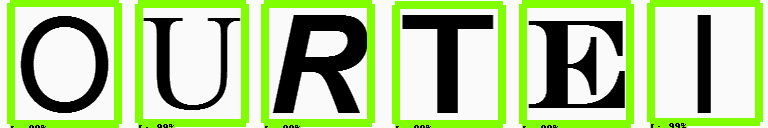

 objetos detectados:  100

>  /content/gdrive/My Drive/IA/demoObjDet-Carteles/Carteles/validation/images/cartel_144_ENCES-ng.png : 


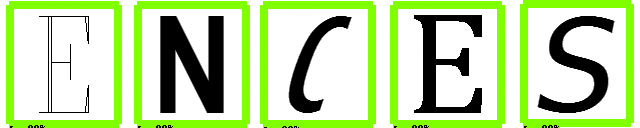

 objetos detectados:  100

>  /content/gdrive/My Drive/IA/demoObjDet-Carteles/Carteles/validation/images/cartel_145_43T-c.png : 


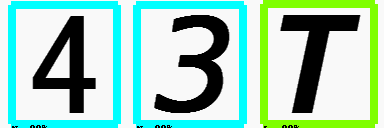

 objetos detectados:  100

>  /content/gdrive/My Drive/IA/demoObjDet-Carteles/Carteles/validation/images/cartel_147_FQQPG6E74-c.png : 


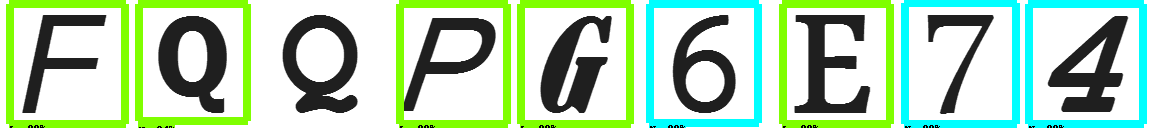

 objetos detectados:  100

>  /content/gdrive/My Drive/IA/demoObjDet-Carteles/Carteles/validation/images/cartel_149_UCL-ng.png : 


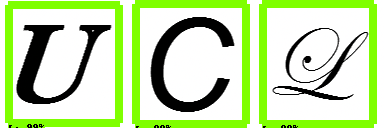

 objetos detectados:  100

>  /content/gdrive/My Drive/IA/demoObjDet-Carteles/Carteles/validation/images/cartel_150_1Q1R8L-c.png : 


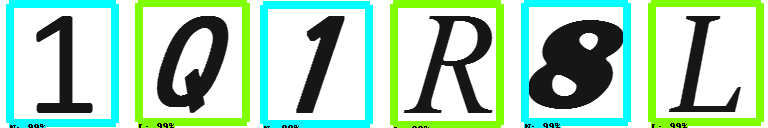

 objetos detectados:  100

>  /content/gdrive/My Drive/IA/demoObjDet-Carteles/Carteles/validation/images/cartel_150_1Q1R8L-nsp.png : 


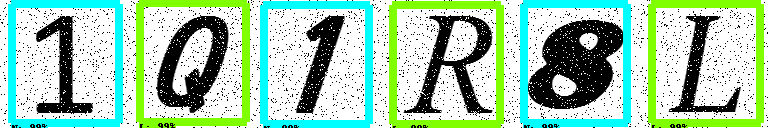

 objetos detectados:  100

>  /content/gdrive/My Drive/IA/demoObjDet-Carteles/Carteles/validation/images/cartel_151_H9EI5ZIF-c.png : 


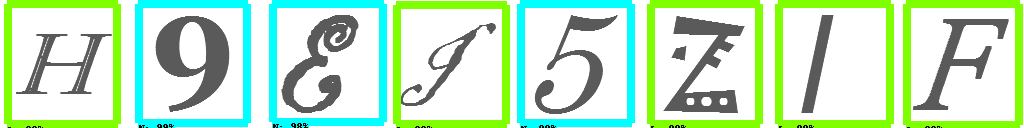

 objetos detectados:  100

>  /content/gdrive/My Drive/IA/demoObjDet-Carteles/Carteles/validation/images/cartel_153_HYDEXV5-ng.png : 


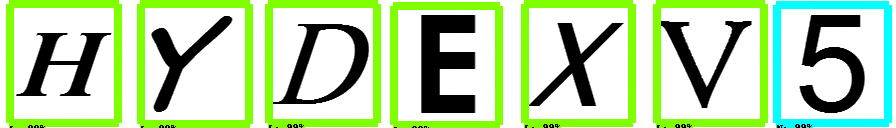

 objetos detectados:  100

>  /content/gdrive/My Drive/IA/demoObjDet-Carteles/Carteles/validation/images/cartel_153_HYDEXV5-nsp.png : 


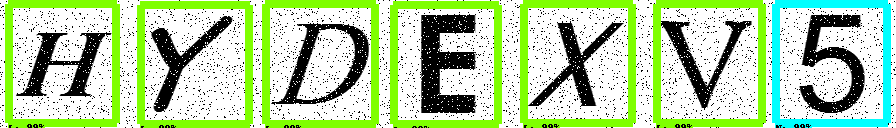

 objetos detectados:  100


In [0]:
# ejecuta el modelo sobre las imágenes cargadas
%cd /content/models/research/object_detection

import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile
from IPython.display import display
from collections import defaultdict
from io import StringIO
from PIL import Image

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops

# This is needed to display the images.
%matplotlib inline

from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util
 
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(
    label_map, max_num_classes=num_classes, use_display_name=True)
category_index = label_map_util.create_category_index(categories)


def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)

# función auxiliar para ejecutar el modelo
def run_inference_for_single_image(image, graph):
    with graph.as_default():
        with tf.Session() as sess:
            # Get handles to input and output tensors
            ops = tf.get_default_graph().get_operations()
            all_tensor_names = {
                output.name for op in ops for output in op.outputs}
            tensor_dict = {}
            for key in [
                'num_detections', 'detection_boxes', 'detection_scores',
                'detection_classes', 'detection_masks'
            ]:
                tensor_name = key + ':0'
                if tensor_name in all_tensor_names:
                    tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
                        tensor_name)
            if 'detection_masks' in tensor_dict:
                # The following processing is only for single image
                detection_boxes = tf.squeeze(
                    tensor_dict['detection_boxes'], [0])
                detection_masks = tf.squeeze(
                    tensor_dict['detection_masks'], [0])
                # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
                real_num_detection = tf.cast(
                    tensor_dict['num_detections'][0], tf.int32)
                detection_boxes = tf.slice(detection_boxes, [0, 0], [
                                           real_num_detection, -1])
                detection_masks = tf.slice(detection_masks, [0, 0, 0], [
                                           real_num_detection, -1, -1])
                detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                    detection_masks, detection_boxes, image.shape[0], image.shape[1])
                detection_masks_reframed = tf.cast(
                    tf.greater(detection_masks_reframed, 0.5), tf.uint8)
                # Follow the convention by adding back the batch dimension
                tensor_dict['detection_masks'] = tf.expand_dims(
                    detection_masks_reframed, 0)
            image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

            # Run inference
            output_dict = sess.run(tensor_dict,
                                   feed_dict={image_tensor: np.expand_dims(image, 0)})

            # all outputs are float32 numpy arrays, so convert types as appropriate
            output_dict['num_detections'] = int(
                output_dict['num_detections'][0])
            output_dict['detection_classes'] = output_dict[
                'detection_classes'][0].astype(np.uint8)
            output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
            output_dict['detection_scores'] = output_dict['detection_scores'][0]
            if 'detection_masks' in output_dict:
                output_dict['detection_masks'] = output_dict['detection_masks'][0]
    return output_dict


# procesa las imágenes cargadas
for image_path in TEST_IMAGE_PATHS:

    print("\n> ",  image_path, ": ")

    # open file to process
    image = Image.open(image_path)

    # the array based representation of the image will be used later in order to prepare the
    # result image with boxes and labels on it.
    image_np = load_image_into_numpy_array(image)

    # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
    image_np_expanded = np.expand_dims(image_np, axis=0)

    # Actual detection.
    output_dict = run_inference_for_single_image(image_np, detection_graph)

    # Visualization of the results of a detection.
    vis_util.visualize_boxes_and_labels_on_image_array(
        image_np,
        output_dict['detection_boxes'],
        output_dict['detection_classes'],
        output_dict['detection_scores'],
        category_index,
        instance_masks=output_dict.get('detection_masks'),
        use_normalized_coordinates=True,
        line_thickness=8)
    
    # muestra la imagen con los objetos detectados
    display( Image.fromarray(image_np, 'RGB') )
    print(" objetos detectados: ", output_dict['num_detections'])
